# Your goal is to predict the values of single unit properties using the observations from 2017.

## From the zillow database for all 'Single Family Residential' properties\
### Acquire:
bedroomcnt\
bathroomcnt\
calculatedfinishedsquarefeet\
taxvaluedollarcnt\
yearbuilt\
taxamount\
fips

In [61]:
import env 
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.stats import pearsonr

In [2]:
# url = env.get_db_url('zillow')

# df_zillow = pd.read_sql(('''select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
#                          taxamount, fips
#                          from properties_2017
#                          join propertylandusetype
#                              using (propertylandusetypeid)
#                          WHERE propertylandusedesc = ("Single Family Residential")'''), url)

In [3]:
def get_zillow():
    '''
    This function acquires zillow data from Codeup MySQL
    '''
    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        url = env.get_db_url('zillow')
        
        df_zillow = pd.read_sql(('''select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
                                 taxamount, fips
                                 from properties_2017
                                 left join propertylandusetype
                                     using (propertylandusetypeid)
                                 WHERE propertylandusedesc = ("Single Family Residential")'''), url)
        df_zillow.to_csv(filename)
    return df_zillow

In [4]:
df_zillow=get_zillow()

In [5]:
# initial look at data
df_zillow.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


## Walk through the summarization and cleaning steps

In [6]:
# Look at data with info to get dtypes
df_zillow.info()

# Title changes: change bedroomcnt to bedrooms, bathroomcnt to bathrooms, calculatedfinishedsquarefeet to sqft, 
# taxvaluedollrcnt to appraisal, yearbuilt to year_built, taxamount to taxes, and fips to city_code

# Dtype changes: change yearbuilt & bedroomcnt.  Fips to obj dtype.  

<class 'pandas.core.frame.DataFrame'>
Index: 2152863 entries, 0 to 2152862
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 131.4 MB


In [7]:
# Rename columns
column_name_changes = {'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 'calculatedfinishedsquarefeet': 
                       'sqft', 'taxvaluedollarcnt': 'appraisal', 'yearbuilt': 'year built', 'taxamount': 'taxes',
                      'fips': 'county'}
df_zillow.rename(columns=column_name_changes, inplace=True)

In [8]:
df_zillow.county.value_counts()

county
6037.0    1431811
6059.0     555077
6111.0     165975
Name: count, dtype: int64

In [9]:
df_zillow.county=df_zillow.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

In [10]:
df_zillow.county

0              LA
1              LA
2              LA
3              LA
4              LA
            ...  
2152858    Orange
2152859    Orange
2152860    Orange
2152861    Orange
2152862        LA
Name: county, Length: 2152863, dtype: object

In [11]:
# get idea for the size of the dataset
df_zillow.shape

(2152863, 7)

In [12]:
# look at summary stats
df_zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathrooms,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
sqft,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
appraisal,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
year built,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxes,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86


In [13]:
df_zillow.dtypes

bedrooms      float64
bathrooms     float64
sqft          float64
appraisal     float64
year built    float64
taxes         float64
county         object
dtype: object

In [14]:
# look at nulls
df_zillow.isnull().sum()

bedrooms        11
bathrooms       11
sqft          8484
appraisal      493
year built    9337
taxes         4442
county           0
dtype: int64

## Examine each feature

In [15]:
df_zillow[df_zillow.bedrooms.isnull()]
# going to convert NaNs to 0 and drop

,bedrooms,bathrooms,sqft,appraisal,year built,taxes,county
107763,NaN,NaN,NaN,67366.0,1926.0,780.54,Orange
118612,NaN,NaN,NaN,43992.0,1946.0,541.64,Orange
193993,NaN,NaN,1348.0,840698.0,1952.0,NaN,Orange
1141339,NaN,NaN,200.0,188972.0,NaN,NaN,LA
1324608,NaN,NaN,990.0,435000.0,1906.0,NaN,LA
1442975,NaN,NaN,NaN,273196.0,NaN,NaN,LA
1647346,NaN,NaN,400.0,28347.0,1954.0,NaN,LA
1701026,NaN,NaN,NaN,407930.0,1926.0,NaN,LA
1722707,NaN,NaN,NaN,477161.0,NaN,NaN,LA
1776422,NaN,NaN,NaN,38855.0,NaN,NaN,LA


In [16]:
df_zillow = df_zillow.dropna()

In [17]:
# dtype changes
df_zillow['year built'] = df_zillow['year built'].astype(int)
df_zillow.bedrooms = df_zillow.bedrooms.astype(int)
df_zillow.county = df_zillow.county.astype(object)

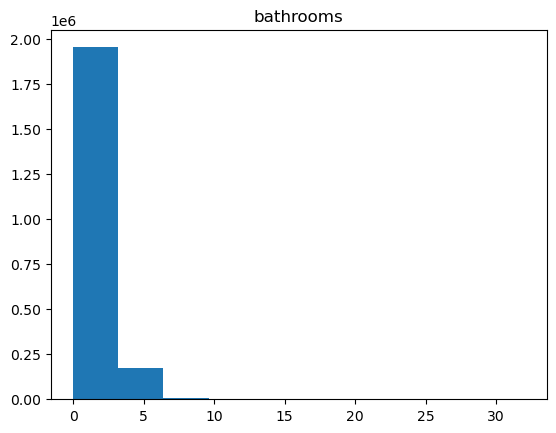

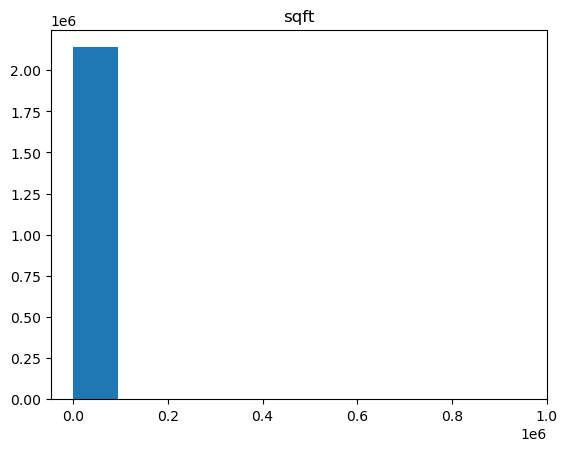

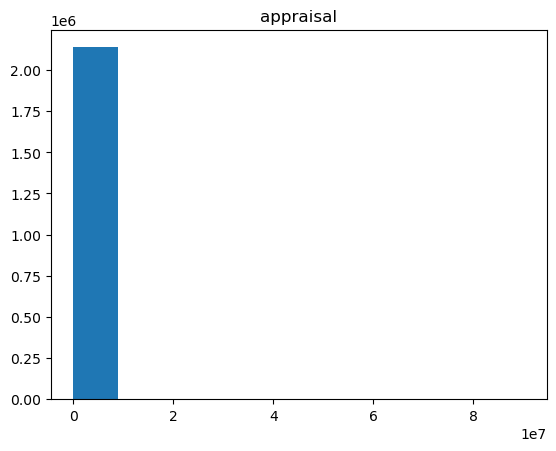

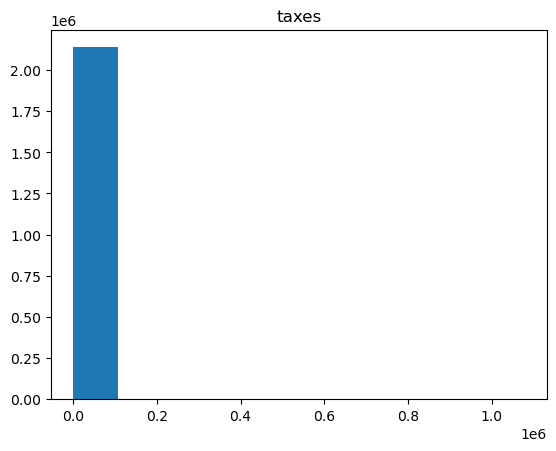

In [18]:
# distributions of float data
num_cols = df_zillow.columns[[df_zillow[col].dtype == 'float64' for col in df_zillow.columns]]
for col in num_cols:
    plt.hist(df_zillow[col])
    plt.title(col)
    plt.show()

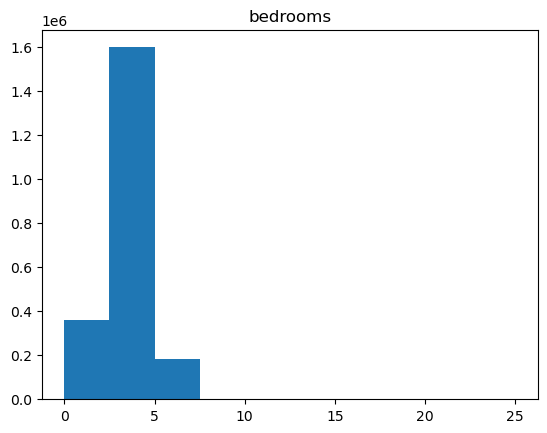

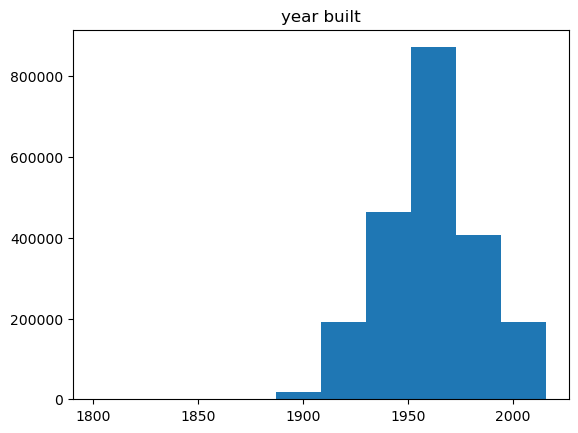

In [19]:
# distributions of float data
num_cols = df_zillow.columns[[df_zillow[col].dtype == 'int64' for col in df_zillow.columns]]
for col in num_cols:
    plt.hist(df_zillow[col])
    plt.title(col)
    plt.show()

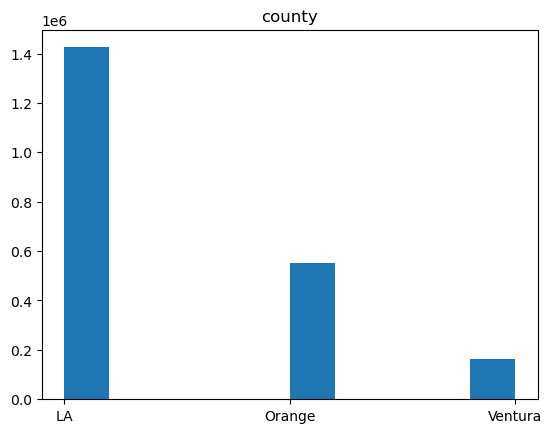

In [20]:
# distributions of float data
num_cols = df_zillow.columns[[df_zillow[col].dtype == 'object' for col in df_zillow.columns]]
for col in num_cols:
    plt.hist(df_zillow[col])
    plt.title(col)
    plt.show()

In [21]:
df_zillow.bedrooms.value_counts(dropna=False)
# no bedrooms...studios?  would have bathroom still.  check bathrooms

bedrooms
3     962944
4     633608
2     334221
5     150671
6      25117
1      22895
7       4792
0       4397
8       1103
9        290
10       118
11        34
13        15
12        12
14         7
15         5
18         3
16         2
25         1
Name: count, dtype: int64

In [22]:
df_zillow[df_zillow.bedrooms == 0]

,bedrooms,bathrooms,sqft,appraisal,year built,taxes,county
11,0,0.0,1200.0,5328.0,1972,91.60,LA
14,0,0.0,171.0,6920.0,1973,255.17,LA
15,0,0.0,203.0,14166.0,1960,163.79,LA
866,0,0.0,220.0,13840.0,1988,327.80,LA
2306,0,0.0,1776.0,79574.0,1989,1137.90,LA
...,...,...,...,...,...,...,...
2146660,0,0.0,676.0,234580.0,1922,3013.57,LA
2149054,0,0.0,938.0,56733.0,1978,986.86,LA
2152505,0,0.0,240.0,31234.0,1942,414.04,LA
2152704,0,1.0,1490.0,152000.0,1930,3614.40,LA


In [23]:
df_zillow.bathrooms.value_counts(dropna=False)

bathrooms
2.00     942463
3.00     422398
1.00     412582
2.50     142827
4.00      82039
1.50      31157
3.50      28464
5.00      28306
4.50      19474
6.00      10717
5.50       6201
7.00       4381
0.00       4274
8.00       1681
6.50       1330
9.00        707
7.50        382
10.00       322
11.00       145
8.50        108
12.00        73
9.50         50
13.00        39
14.00        25
15.00        17
0.50         16
10.50        14
16.00        12
18.00         8
20.00         6
17.00         4
1.75          3
12.50         3
11.50         3
19.50         1
14.50         1
32.00         1
19.00         1
Name: count, dtype: int64

In [24]:
df_zillow = df_zillow[(df_zillow['bedrooms'] != 0) & (df_zillow['bathrooms'] != 0)]

In [25]:
df_zillow[df_zillow.bedrooms == 0]

,bedrooms,bathrooms,sqft,appraisal,year built,taxes,county


In [26]:
df_zillow[df_zillow.bathrooms == 0]

,bedrooms,bathrooms,sqft,appraisal,year built,taxes,county


In [27]:
df_zillow['bedrooms'].unique()

array([ 4,  3,  5,  2,  1,  6,  7,  8,  9, 25, 10, 11, 14, 15, 13, 12, 16,
       18])

In [30]:
def prep_zillow(df):
    '''
    this function prepares zillow data by changing column names, a few dtypes, dropping nulls, and houses with 0 bedrooms and 0 bathrooms.
    '''
    column_name_changes = {'bedroomcnt': 'bedrooms',
                           'bathroomcnt': 'bathrooms',
                           'calculatedfinishedsquarefeet': 'sqft',
                           'taxvaluedollarcnt': 'appraisal',
                           'yearbuilt': 'year built',
                           'taxamount': 'taxes',
                           'fips': 'county'}
    
    df.rename(columns=column_name_changes, inplace=True)
    
    df = df.dropna()
    
    # dtype changes
    df['year built'] = df['year built'].astype(int)
    df.bedrooms = df.bedrooms.astype(int)
    df.county = df.county.astype(object)
    
    df_zillow.county=df_zillow.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})
    
    df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]
    
    return df


In [31]:
df_zillow=prep_zillow(df_zillow)
df_zillow.head()

,bedrooms,bathrooms,sqft,appraisal,year built,taxes,county
4,4,2.0,3633.0,296425.0,2005,6941.39,LA
6,3,4.0,1620.0,847770.0,2011,10244.94,LA
7,3,2.0,2077.0,646760.0,1926,7924.68,LA
18,3,1.0,1244.0,169471.0,1950,2532.88,LA
19,3,2.0,1300.0,233266.0,1950,3110.99,LA


In [32]:
def split_data(df):
    '''
   
    '''
    train, validate_test = train_test_split(df,
                                            train_size=0.60,
                                            random_state=123,
                                            )

 
    validate, test = train_test_split(validate_test,
                                      test_size=0.50,
                                      random_state=123,
                                      )
    # Apply county mapping to all datasets
    county_mapping = {6037: 'LA', 6059: 'Orange', 6111: 'Ventura'}

    train['county'] = train['county'].map(county_mapping)
    validate['county'] = validate['county'].map(county_mapping)
    test['county'] = test['county'].map(county_mapping)


    return train, validate, test

In [33]:
train, validate, test=split_data(df_zillow)
train.shape, validate.shape, test.shape


((1280945, 7), (426982, 7), (426982, 7))

In [34]:
train.county

778024     NaN
1646075    NaN
1905298    NaN
620197     NaN
393229     NaN
          ... 
1971325    NaN
1251420    NaN
28288      NaN
280285     NaN
780130     NaN
Name: county, Length: 1280945, dtype: object

## Create final function called wrangle_zillow

In [35]:
def wrangle_function():
    train, validate, test=split_data(prep_zillow(get_zillow()))
    
    return train, validate, test

In [36]:
train, validate, test=wrangle_function()

In [37]:
train.shape

(1280945, 7)

In [38]:
train.county

778024          LA
1646075     Orange
1905298         LA
620197          LA
393229          LA
            ...   
1971325         LA
1251420         LA
28288           LA
280285     Ventura
780130          LA
Name: county, Length: 1280945, dtype: object

In [39]:
# # Create subsets for each combination of contract type, internet service type, and payment type
# subgroups = ['appraisal', 'bedrooms', 'taxes', 'year built']

# # Get the number of unique combinations for subplot layout
# num_subplots = len(subgroups)

# # Set up the subplot grid
# num_cols = 2  # Number of columns in the subplot grid
# num_rows = (num_subplots + 1) // num_cols  # Calculate the number of rows

# # Create subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# # Flatten the axes for easier iteration
# axes = axes.flatten()

# # Iterate through subgroups and create boxplots
# for i, subgroup in enumerate(subgroups):
#     sns.boxplot(x='county', y=subgroup, data=train, ax=axes[i])
#     axes[i].set_title(f'County by {subgroup}')
#     axes[i].set_xlabel('county')
#     axes[i].set_ylabel(subgroup)

# # Adjust layout for better appearance
# plt.tight_layout()
# plt.show()

# Heatmap showing correllations

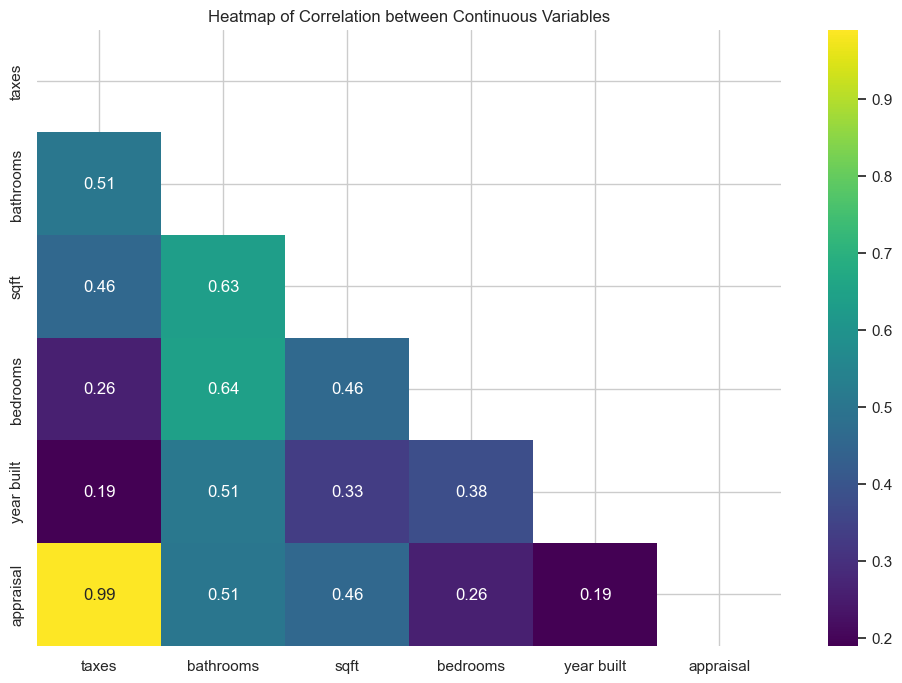

In [73]:
subgroups = ['taxes', 'bathrooms','sqft','bedrooms','year built']

# Create a heatmap with upper triangular part masked
plt.figure(figsize=(12, 8))
correlation_matrix = train[subgroups + ['appraisal']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))

plt.title('Heatmap of Correlation between Continuous Variables')
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


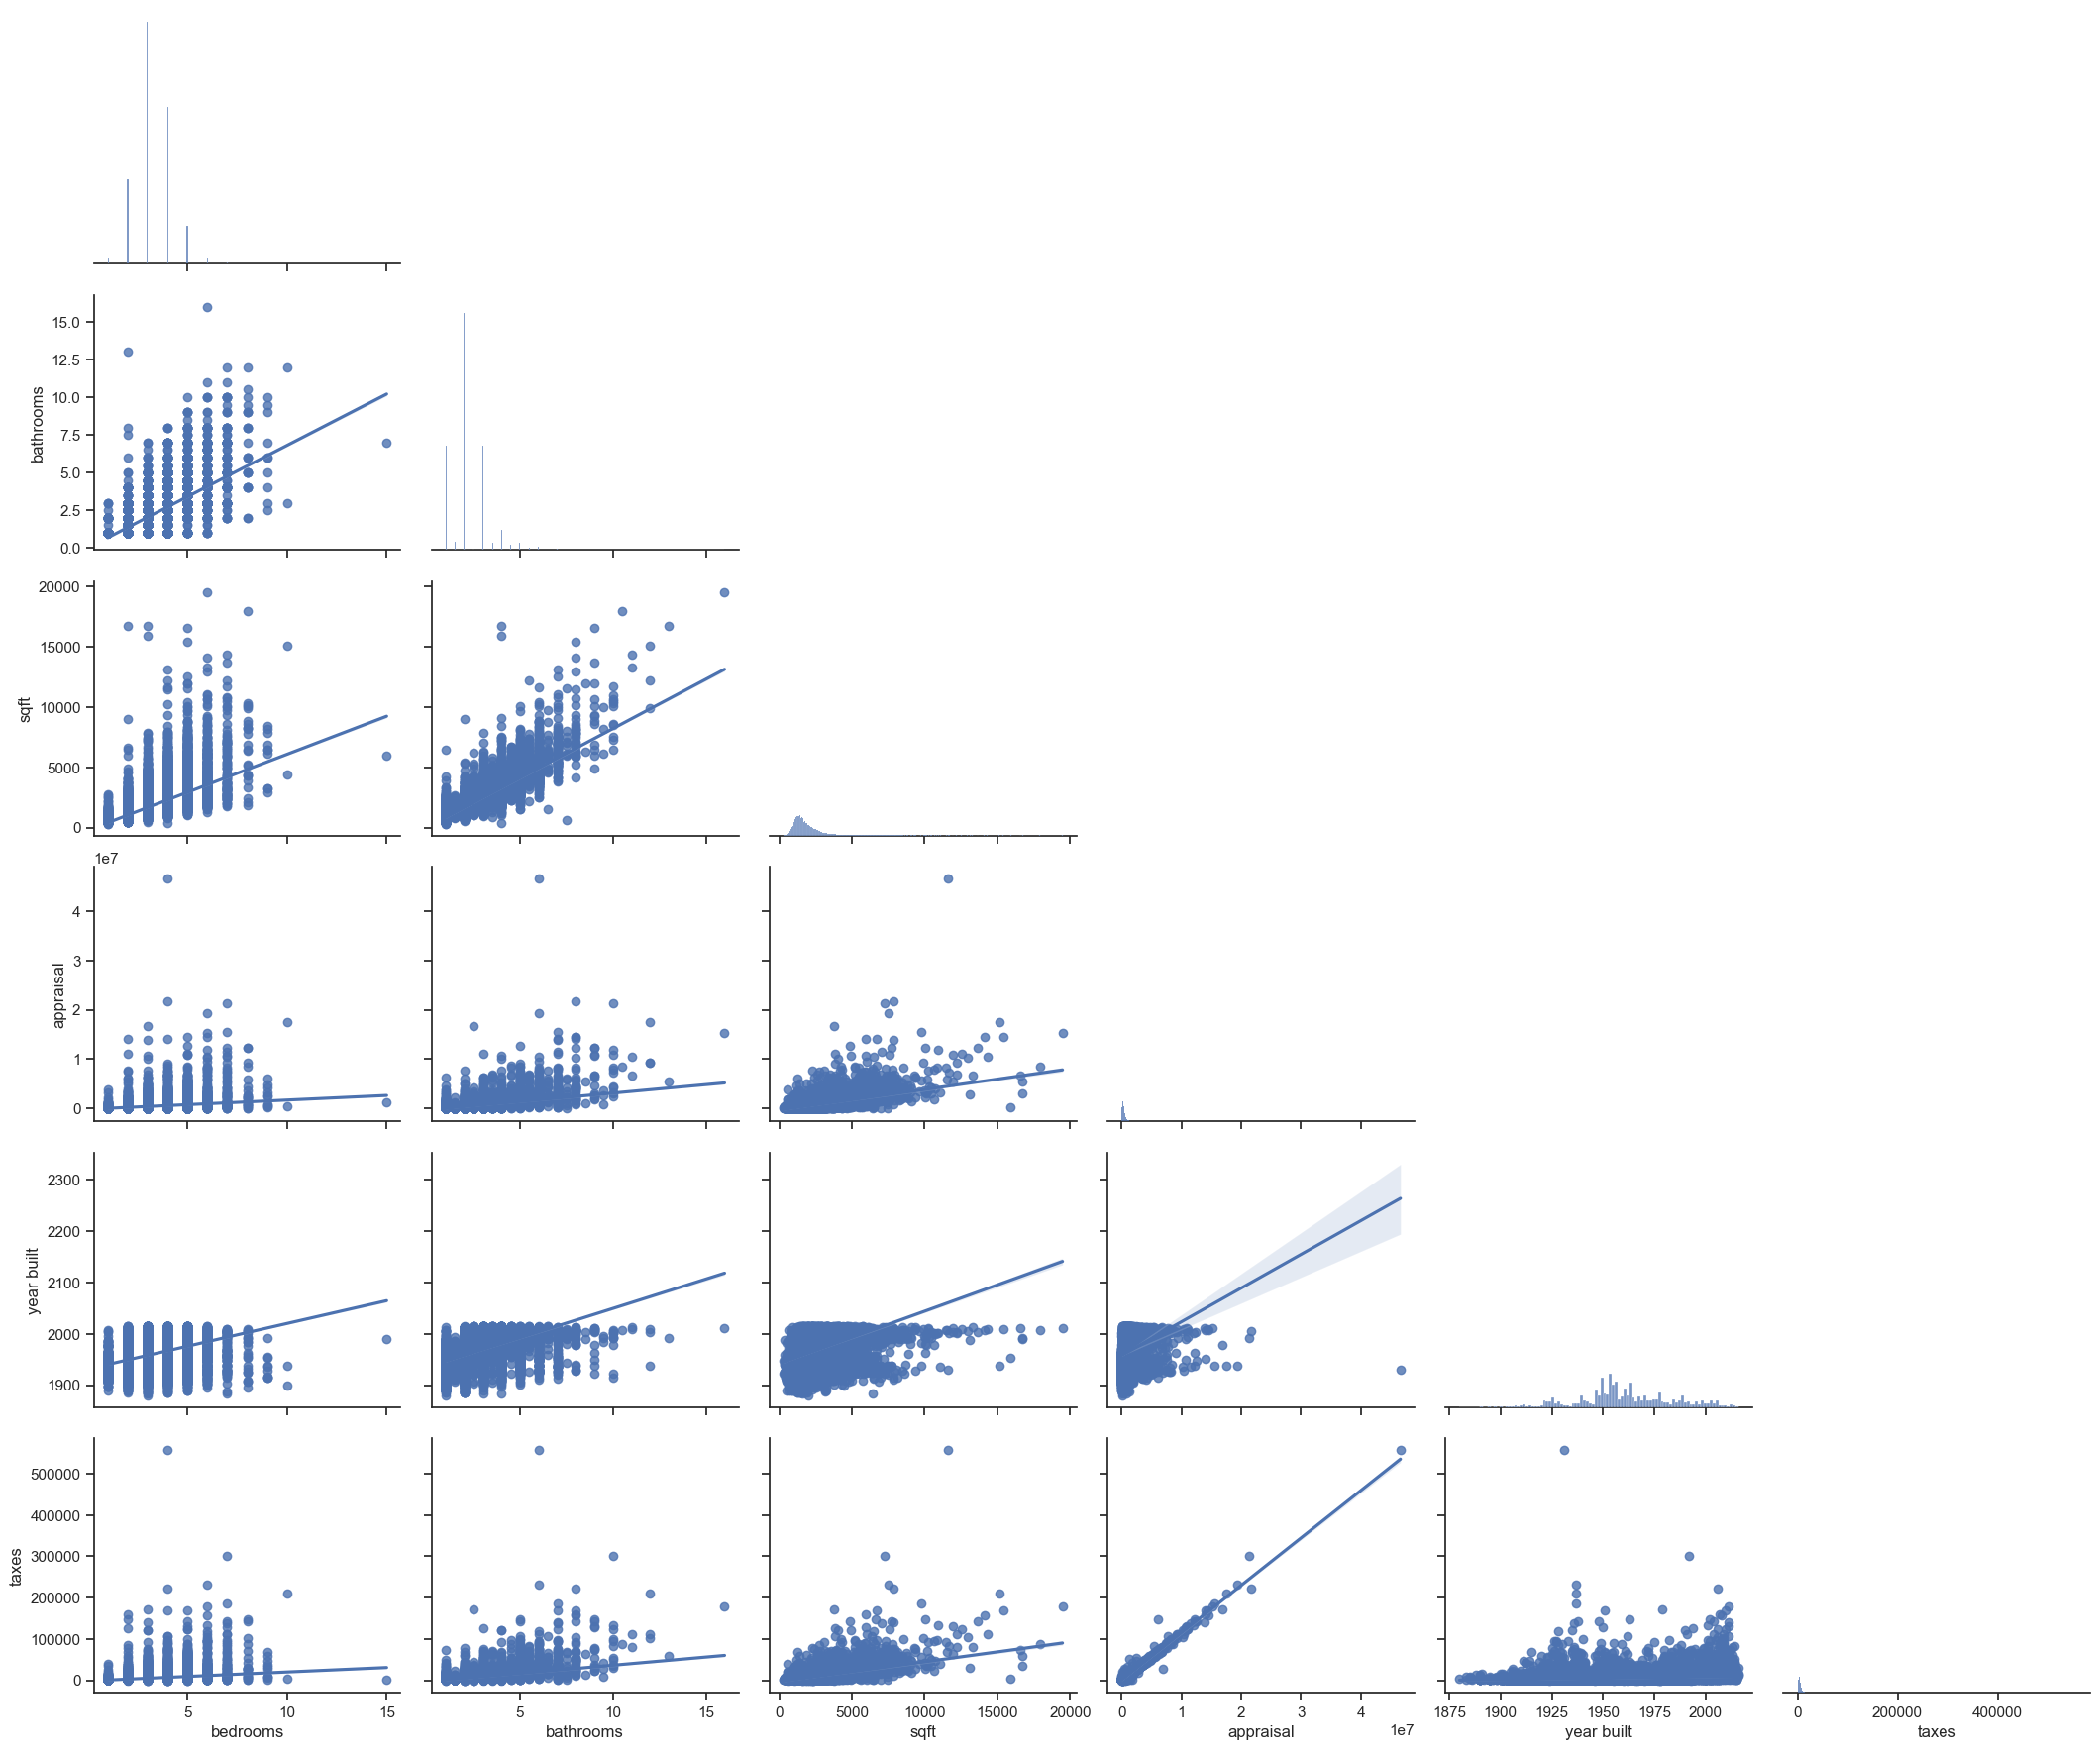

In [46]:
def plot_variable_pairs(df):
    '''
    Plots all pairwise relationships along with the regression line for each pair.

    Parameters:
    - df: train data as input.

    '''
    sns.set(style="ticks")
    
    # Create a pairplot with regression lines
    sns.pairplot(df, kind='reg', height=3, aspect=1.2, corner=True)
    
    # Show the plot
    plt.show()

# Execute function
plot_variable_pairs(train.sample(50000))

##### Insights: Appraisal top correlated features are taxes, bathrooms, and sqft.  Will be features incorporated into modeling

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 51.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 73.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 62.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/cat

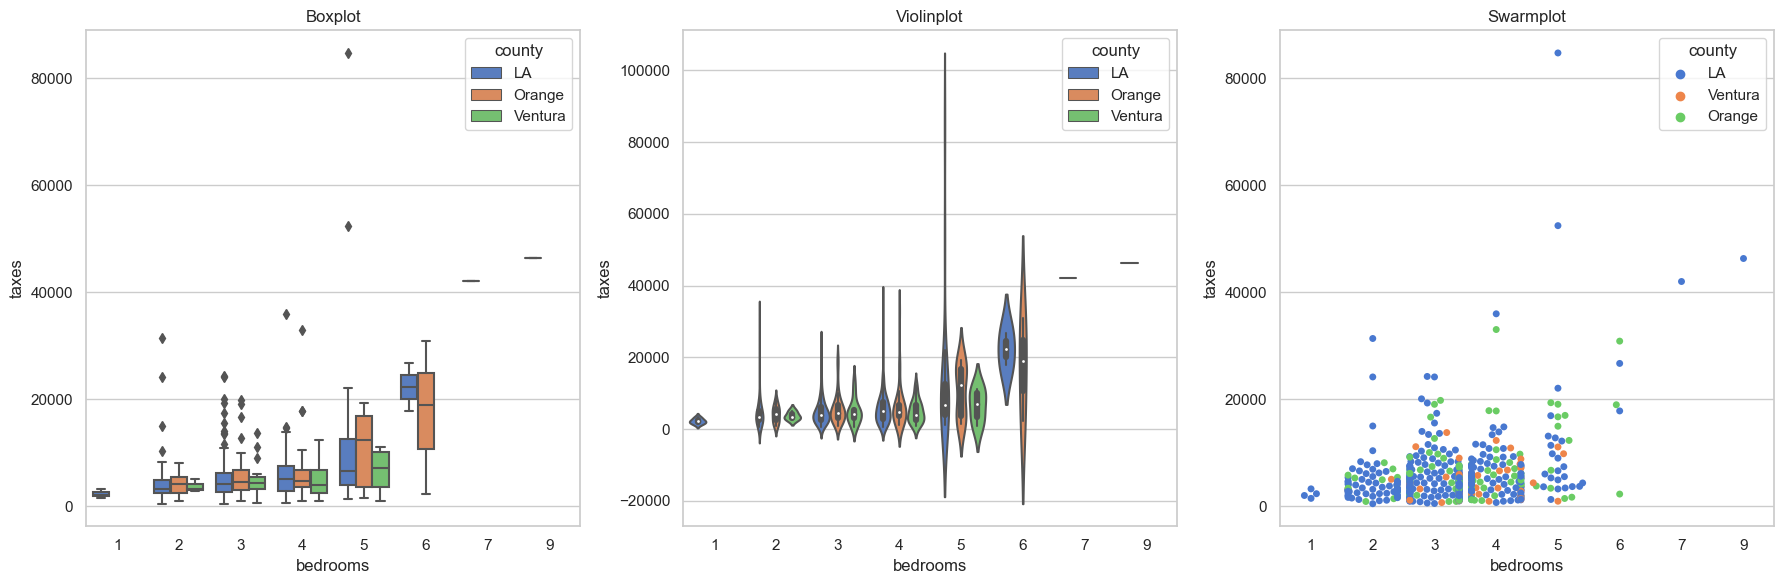

In [83]:
def plot_categorical_and_continuous_vars(df, categorical_var, continuous_var):
    """
    Visualizes the relationship between a categorical variable and a continuous variable using three different plots.

    """
    # Set up the subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Boxplot
    sns.boxplot(x=categorical_var, y=continuous_var, hue='county', data=df, ax=axes[0])
    axes[0].set_title('Boxplot')

    # Plot 2: Violinplot
    sns.violinplot(x=categorical_var, y=continuous_var, hue='county', data=df, ax=axes[1])
    axes[1].set_title('Violinplot')

    # Plot 3: Swarmplot
    sns.swarmplot(x=categorical_var, y=continuous_var, hue='county',data=df, ax=axes[2])
    axes[2].set_title('Swarmplot')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# execute function
plot_categorical_and_continuous_vars(train.sample(500), 'bedrooms', 'taxes')

# Categorical Variable Evaluation

## Set large values to log scale

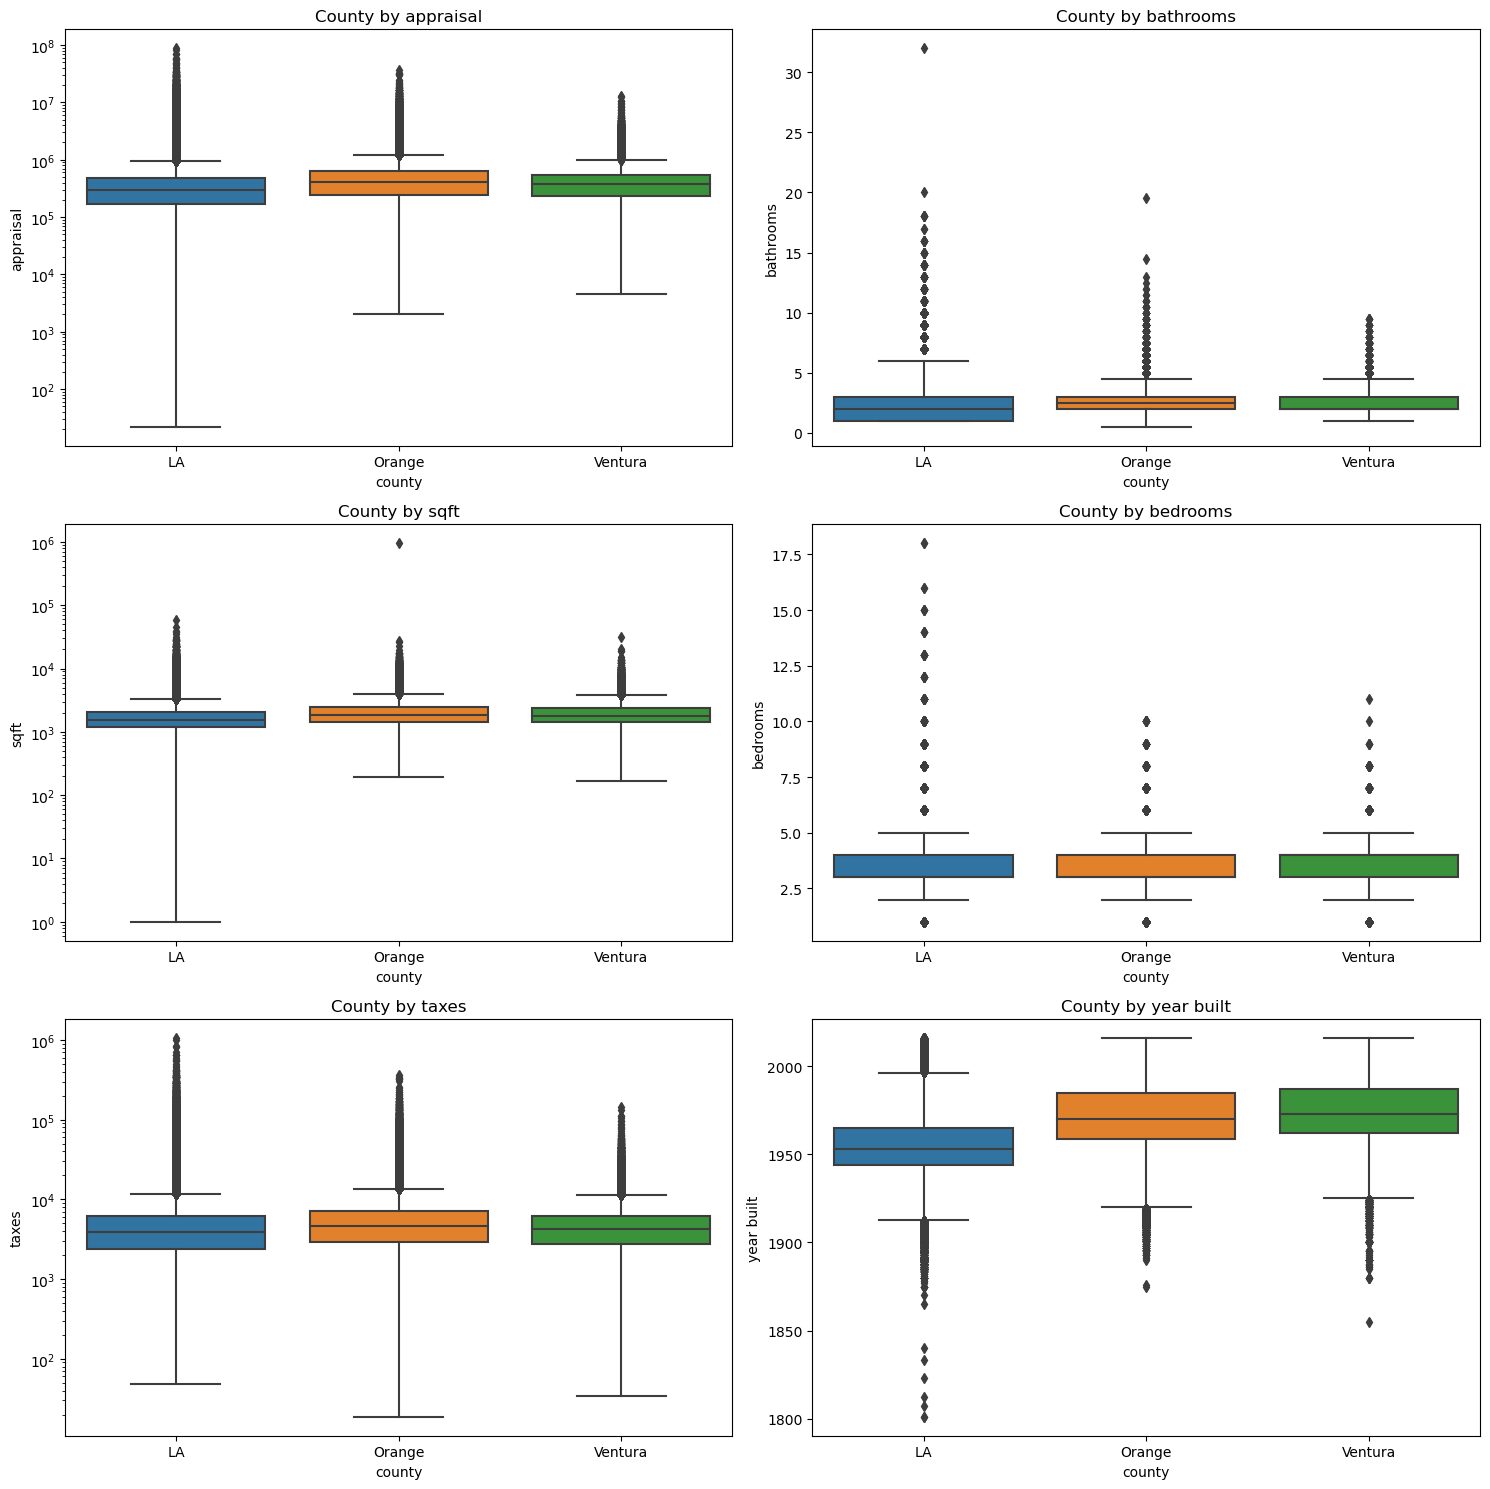

In [42]:
# Create subsets for each combination of contract type, internet service type, and payment type
subgroups = ['appraisal', 'bathrooms','sqft','bedrooms', 'taxes', 'year built']

# Get the number of unique combinations for subplot layout
num_subplots = len(subgroups)

# Set up the subplot grid
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_subplots + 1) // num_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through subgroups and create boxplots
for i, subgroup in enumerate(subgroups):
    sns.boxplot(x='county', y=subgroup,data=train, ax=axes[i])

    if subgroup in ['appraisal', 'taxes', 'sqft']:
        axes[i].set_yscale('log')  # Apply logarithmic scale to y subgroups

    axes[i].set_title(f'County by {subgroup}')
    axes[i].set_xlabel('county')
    axes[i].set_ylabel(subgroup)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


#### Insights: Don't feel any info is really valuable

## Statistical Testing of County to Features included in Modeling

In [48]:
# Create subsets for each combination of contract type, internet service type, and payment type
subgroups = ['appraisal', 'bathrooms','sqft','bedrooms', 'taxes', 'year built']

def explore_categorical(train, target, subgroup, alpha=0.05):
    '''
    Explore the relationship between a binary target variable and a categorical variable.

    Parameters:
    train: The training data split set.
    target (str): The name of the binary target variable.
    cat_var (str): The name of the categorical variable to explore.
    alpha (float): Significance level for hypothesis testing.

    '''
    # Print the name of the categorical variable
    print()
    print(subgroup, '&', target)
    print('')

    # Calculate the chi-squared test statistic, p-value, degrees of freedom, and expected values
    ct = pd.crosstab(train[subgroup], train[target], margins=True)
    chi2, p, dof, expected = stats.chi2_contingency(ct)
    print(f"Chi2: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print('')

    # Check for statistical significance
    if p < alpha:
        print('The null hypothesis can be rejected due to statistical significance.')
        print('Ergo there is a relationship between the target variable and corresponding feature(s)')
    else:
        print('The null hypothesis cannot be rejected at the chosen significance level.')
        print('Ergo there is not a relationship between the target variable and corresponding feature(s)')

        
# loop through categories creating category variables (cat_var) for use in explore function for Chi2 test
for subgroup in subgroups:
    explore_categorical(train, 'county', subgroup)


appraisal & county

Chi2: 1624907.2179770994
P-value: 0.0
Degrees of Freedom: 1334622

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

bathrooms & county

Chi2: 343061.5070700102
P-value: 0.0
Degrees of Freedom: 108

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

sqft & county

Chi2: 162681.55548490403
P-value: 0.0
Degrees of Freedom: 28200

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

bedrooms & county

Chi2: 44630.75671383564
P-value: 0.0
Degrees of Freedom: 51

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

taxes & county

Chi2: 1498438.3026875253
P-val

##### Statistical Testing of categorical variable confirms county also has a relationship to appraisal, bathrooms, and sqft, but does not have a relationship to taxes.  Furthermore county has a relationship to year built and bedrooms.  For regression modeling county, appraisal, bathrooms, and sqft will be the key features

In [56]:
### Very Ugly Graph ###

# # Create subsets for each combination of contract type, internet service type, and payment type
# subgroups = ['appraisal', 'taxes', 'sqft']

# # Get the number of unique combinations for subplot layout
# num_subplots = len(subgroups)

# # Set up the subplot grid
# num_cols = 2  # Number of columns in the subplot grid
# num_rows = (num_subplots + 1) // num_cols  # Calculate the number of rows

# # Create subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# # Flatten the axes for easier iteration
# axes = axes.flatten()

# # Iterate through subgroups and create boxplots
# for i, subgroup in enumerate(subgroups):
#     sns.boxplot(x='bathrooms', y=subgroup,hue='county',data=train, ax=axes[i])

#     if subgroup in ['appraisal', 'taxes', 'sqft']:
#         axes[i].set_yscale('log')  # Apply logarithmic scale to y subgroups

#     axes[i].set_title(f'Bathrooms by {subgroup}')
#     axes[i].set_xlabel('Bathrooms')
#     axes[i].set_ylabel(subgroup)

# # Adjust layout for better appearance
# plt.tight_layout()
# plt.show()


# Scatterplots on Log scale to subgroups

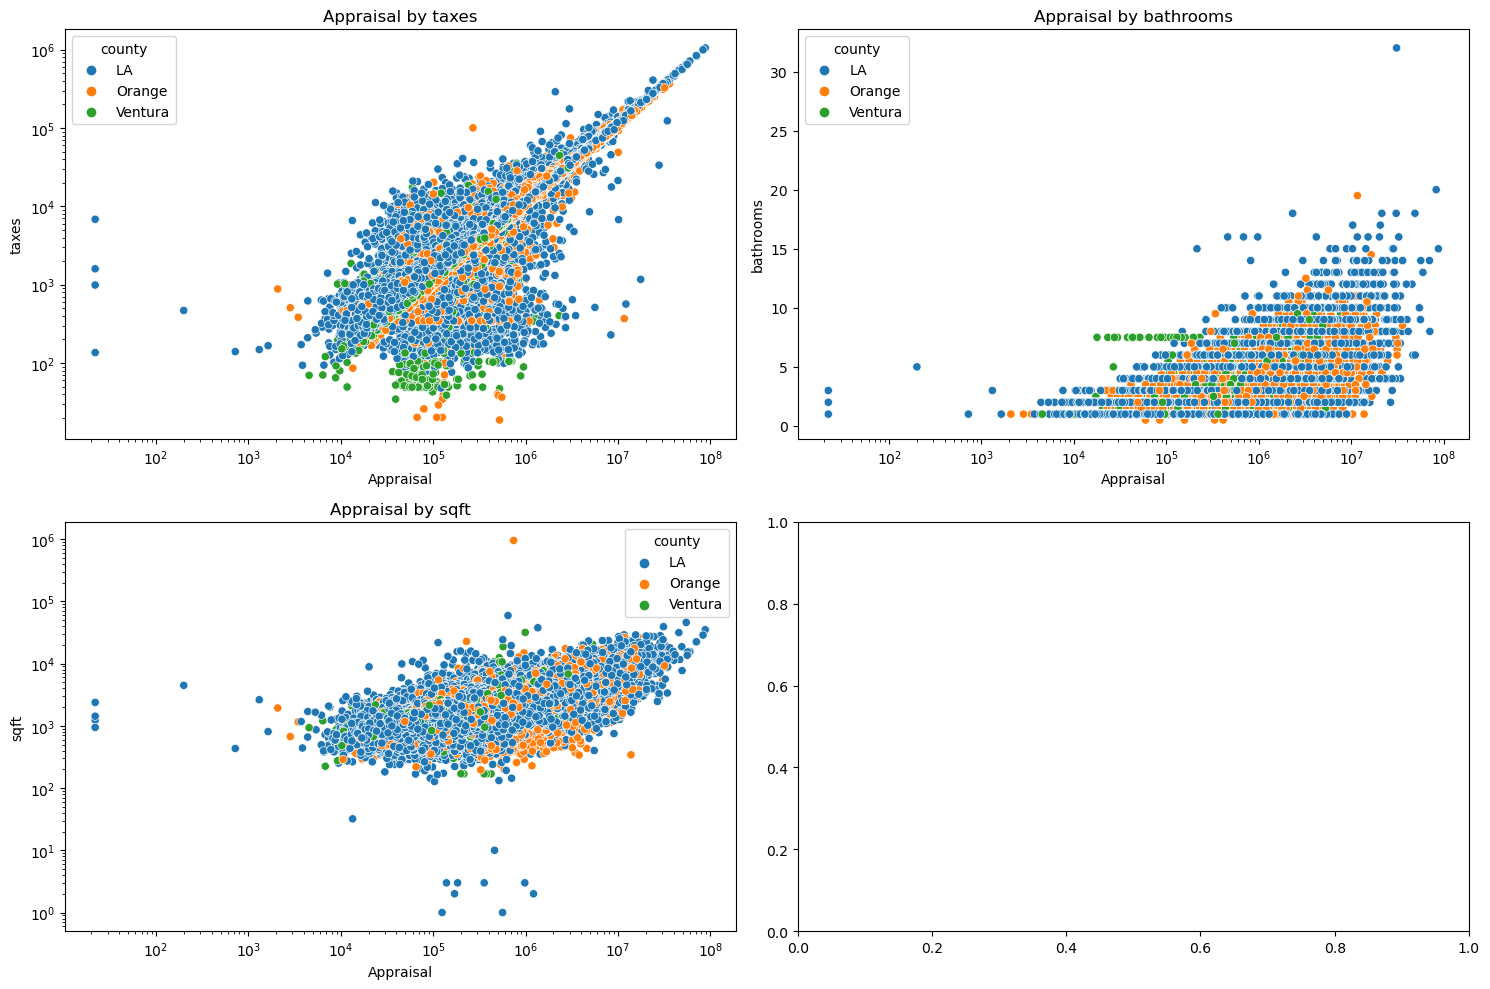

In [55]:
# Create subsets for enumeration
subgroups = ['taxes', 'bathrooms', 'sqft']

# Get the number of unique combinations for subplot layout
num_subplots = len(subgroups)

# Set up the subplot grid
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_subplots + 1) // num_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through subgroups and create boxplots
for i, subgroup in enumerate(subgroups):
    sns.scatterplot(x='appraisal', y=subgroup,hue='county',data=train, ax=axes[i])

    if subgroup in ['taxes', 'sqft']:
        axes[i].set_yscale('log')  # Apply logarithmic scale to 'appraisal' and 'taxes'

    axes[i].set_xscale('log')  # Apply logarithmic scale to x
    
    axes[i].set_title(f'Appraisal by {subgroup}')
    axes[i].set_xlabel('Appraisal')
    axes[i].set_ylabel(subgroup)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

##### Statistical Testing of Key Feature Continuous Variables

 $h_0$: There is no significant correlation between target and subgroups
 $h_a$: There is a significant correlation between target and subgroups

In [94]:
# Create subsets for enumeration
subgroups = ['taxes', 'bathrooms', 'sqft']


def explore_continuous(train, target, subgroups, alpha=0.05):
    '''
    Explore the relationship between a binary target variable and continuous variables.

    Parameters:
    - train: The training data split set.
    - target (str): The name of the binary target variable.
    - subgroups (list): The list of continuous variables to explore.
    - alpha (float): Significance level for hypothesis testing.
    '''
    # Loop through each continuous variable
    for subgroup in subgroups:
        # Print the name of the continuous variable
        print(f"\n{subgroup} & {target}\n")

        # Perform Pearson correlation test
        correlation_coefficient, p_value = pearsonr(train[target], train[subgroup])

        # Print results
        print(f"Pearson correlation coefficient for {subgroup}: {correlation_coefficient:.4f}, p-value: {p_value:.4f}\n")

        # Check for statistical significance
        if p_value < alpha:
            print('The null hypothesis can be rejected due to statistical significance.')
            print('Ergo there is a relationship between the target variable and corresponding feature(s)\n')
        else:
            print('The null hypothesis cannot be rejected at the chosen significance level.')
            print('Ergo there is not a relationship between the target variable and corresponding feature(s)\n')

# Test function
explore_continuous(train, 'appraisal', subgroups)



taxes & appraisal

Pearson correlation coefficient for taxes: 0.9903, p-value: 0.0000

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)


bathrooms & appraisal

Pearson correlation coefficient for bathrooms: 0.5055, p-value: 0.0000

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)


sqft & appraisal

Pearson correlation coefficient for sqft: 0.4579, p-value: 0.0000

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)



In [69]:
# Perform Pearson correlation test

# Create subsets for enumeration
subgroups = ['taxes', 'bathrooms', 'sqft']

alpha = 0.05  # Set your significance level

for subgroup in subgroups:
    correlation_coefficient, p_value = pearsonr(train['appraisal'], train[subgroup])
    print(f"Pearson correlation coefficient for {subgroup}: {correlation_coefficient:.4f}, p-value: {p_value:.4f}")
    print()
    # Check for statistical significance
    if p_value < alpha:
        print('The null hypothesis can be rejected due to statistical significance.')
        print('Ergo there is a relationship between the target variable and corresponding feature(s)')
        print()
    else:
        print('The null hypothesis cannot be rejected at the chosen significance level.')
        print('Ergo there is not a relationship between the target variable and corresponding feature(s)')
        print()


Pearson correlation coefficient for taxes: 0.9903, p-value: 0.0000

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

Pearson correlation coefficient for bathrooms: 0.5055, p-value: 0.0000

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)

Pearson correlation coefficient for sqft: 0.4579, p-value: 0.0000

The null hypothesis can be rejected due to statistical significance.
Ergo there is a relationship between the target variable and corresponding feature(s)



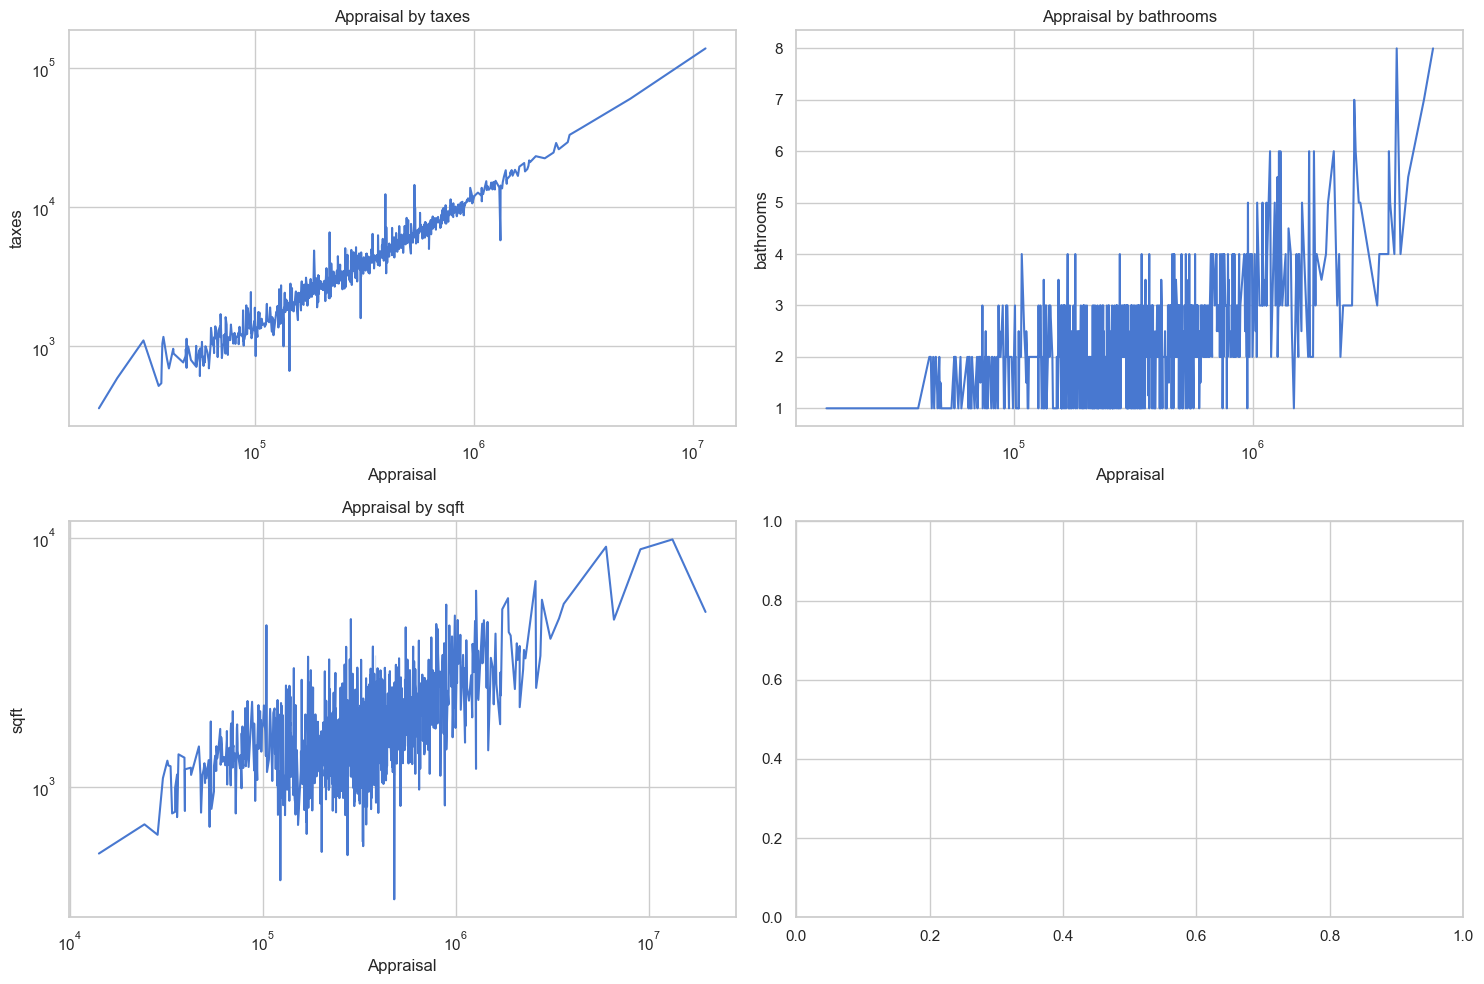

In [99]:
# Create subsets for enumeration
subgroups = ['taxes', 'bathrooms', 'sqft']

# Get the number of unique combinations for subplot layout
num_subplots = len(subgroups)

# Set up the subplot grid
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_subplots + 1) // num_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through subgroups and create boxplots
for i, subgroup in enumerate(subgroups):
    sns.lineplot(x='appraisal', y=subgroup,data=train.sample(1000), ax=axes[i])

    if subgroup in ['taxes', 'sqft']:
        axes[i].set_yscale('log')  # Apply logarithmic scale to 'appraisal' and 'taxes'

    axes[i].set_xscale('log')  # Apply logarithmic scale to x
    
    axes[i].set_title(f'Appraisal by {subgroup}')
    axes[i].set_xlabel('Appraisal')
    axes[i].set_ylabel(subgroup)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

In [ ]:
# # Create subsets for enumeration
# subgroups = ['taxes', 'bathrooms', 'sqft']

# def plot_all_continuous_vars(train, target, subgroups):
#     '''
#     Melt the dataset to "long-form" representation
#     boxenplot of measurement x value with color representing the target variable. 
#     '''
#     sns.set(style="whitegrid", palette="muted")
    
#     # Create subplots
#     fig, axes = plt.subplots(nrows=len(subgroups), ncols=1, figsize=(8, 6 * len(subgroups)))

#     for i, subgroup in enumerate(subgroups):
#         # Melt the dataset for the current subgroup
#         melt = train[[subgroup, target]].melt(id_vars=target, var_name=subgroup)

#         # Create a boxenplot for the current subgroup
#         sns.boxenplot(x=subgroup, y="value", hue=target, data=melt, ax=axes[i])

#         # Apply log scale to the y-axis if needed
#         if subgroup in ['sqft', 'taxes']:
#             axes[i].set_yscale('log')

#         axes[i].set_xscale('log')  # Apply logarithmic scale to x
        
#         axes[i].set_xlabel(subgroup)
#         axes[i].set_ylabel('Value')
#         axes[i].set_title(f'{subgroup} by {target}')

#     plt.tight_layout()
#     plt.show()
#     print()
#     print()

# # Execute Function
# plot_all_continuous_vars(train.sample(100), 'appraisal', subgroups)
